# Data Engineering Case Study
## Part 1: Exploratory Data Analysis
### - By Mendel Lerner

### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
import matplotlib.ticker as mtick
%reload_ext watermark
%matplotlib inline

In [2]:
print('')
%watermark -a "Mendel Lerner" -nv --packages numpy,pandas,matplotlib,seaborn
print('')


Mendel Lerner Thu Sep 24 2020 

CPython 3.8.3
IPython 7.16.1

numpy 1.18.5
pandas 1.0.5
matplotlib 3.2.2
seaborn 0.10.1



### The Business Task

Create an exploratory data analysis project of Lending Club's loan origination data from 2007-2018. Load the data and perform any necessary cleaning and aggregations to explore and better understand the dataset. Based on your exploration, please describe your high level findings in a few sentences. Please include two data visualizations and two summary statistics to support these findings.

### Data Cleaning

In [3]:
# Load Dataset
df = pd.read_csv('data/accepted_2007_to_2018Q4.csv', parse_dates = ['issue_d','earliest_cr_line', 'last_pymnt_d'])

C:\Users\mende\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# dfs = df

# # We want to analyze the data in general. Therefore we remove columns with NaNs => 75%.
# def data_nulls(df, show = False):
#     # Nulls by column
#     null_df = pd.DataFrame(df.isnull().sum(), columns = ['Missing'], dtype = np.int64)
#     null_df['Percent'] = null_df['Missing'].transform(lambda x: x/len(df)).replace(np.nan,0)
#     if show: display(null_df.apply('{:.2%}'.format))
#     return null_df

# dfs_null_percent = data_nulls(dfs)
# dfs_null_cols = dfs_null_percent[dfs_null_percent.Percent < .75].index.tolist()
# ncols = len(dfs.columns)
# dfs = dfs[dfs_null_cols]
# print(f'Dropped {str(ncols - len(dfs.columns))} columns')

### Select columns for high-level analysis

In [5]:
# Identify the columns we'll be keeping from the dataset for the high-level analysis
# We choose funded amount as the loan amount
cols_to_pick = ['funded_amnt','term','int_rate', 'grade','emp_length', 'home_ownership',
                 'annual_inc','verification_status','issue_d',
                 'loan_status','purpose','dti', 'delinq_2yrs',
                 'earliest_cr_line','open_acc', 'fico_range_high', 'fico_range_low', 'total_pymnt', 'recoveries', 'last_pymnt_d']
dfs = df[cols_to_pick].copy()
dfs.head(2).T

,0,1
funded_amnt,3600,24700
term,36 months,36 months
int_rate,13.99,11.99
grade,C,C
emp_length,10+ years,10+ years
home_ownership,MORTGAGE,MORTGAGE
annual_inc,55000,65000
verification_status,Not Verified,Not Verified
issue_d,2015-12-01 00:00:00,2015-12-01 00:00:00
loan_status,Fully Paid,Fully Paid


### Typecast the columns

In [6]:
# Identify the type of each column
float_cols = ['funded_amnt', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'fico_range_high', 'fico_range_low', 'total_pymnt', 'recoveries', 'int_rate']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(date_cols) == set()

In [7]:
for i in float_cols:
    dfs[i] = dfs[i].astype(float)

for i in cat_cols:
    dfs.loc[dfs[i].isnull(), i] = None

### Engineer Features

In [8]:
dfs['loan_length'] = (dfs.last_pymnt_d - dfs.issue_d) / np.timedelta64(1, 'Y')

In [9]:
# Get average fico score from range
dfs['avg_fico'] = dfs[['fico_range_high', 'fico_range_low']].mean(axis = 1)

In [10]:
# Create year column
dfs['issue_year'] = df.issue_d.dt.year

In [11]:
# Categorize loans into current and defaulted
dfs.loc[dfs.loan_status.isin(['Does not meet the credit policy. Status:Fully Paid','Fully Paid']), 'loan_status'] = 'Fully Paid'
dfs.loc[dfs.loan_status.isin(['Charged Off', 'In Grace Period', 'Late (31-120 days)', 'Late (16-30 days)', 'Default', np.nan, 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off']), 'loan_status'] = 'Default'

In [12]:
# Calculate rate of return using simple annualized profit margin
dfs['total_return_perc'] = (dfs[['total_pymnt']].sum(axis = 1) - dfs.funded_amnt)/dfs.funded_amnt*100
dfs['rate_of_return'] = dfs.total_return_perc / (dfs['loan_length'])
# There exist more optimistic rate of return calculations
# We can be optimistic about 'Current' loans that they will continue paying until the official end date without defaulting or paying back early
dfs.loc[dfs.loan_status == 'Current', 'rate_of_return'] = dfs.loc[dfs.loan_status == 'Current', 'int_rate']

In [13]:
dfs['credit_yrs_before_loan'] = dfs['issue_year'] - dfs.earliest_cr_line.dt.year
dfs.head(2).T

,0,1
funded_amnt,3600,24700
term,36 months,36 months
int_rate,13.99,11.99
grade,C,C
emp_length,10+ years,10+ years
home_ownership,MORTGAGE,MORTGAGE
annual_inc,55000,65000
verification_status,Not Verified,Not Verified
issue_d,2015-12-01 00:00:00,2015-12-01 00:00:00
loan_status,Fully Paid,Fully Paid


### Data Cleaning

Deal with null values. We allow categorical variables to be null **other than** grade, which is a particularly important piece of information. All non-categorical variables must be non-null, and we drop rows that do not meet this requirement.

In [14]:
required_cols = set(cols_to_pick) - set(cat_cols)
required_cols.add("grade")

n_rows = len(dfs)
dfs.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(dfs)) + " rows")

Removed 4196 rows


In [15]:
# Clean 'emp_length' column
dfs['emp_length'] = dfs.emp_length.fillna(value = '0 years').replace({'< 1 year': '0 years', '10+ years': '10 years'}).str.extract('(\d+)',expand=False).astype(int)

In [16]:
# Clean 'term' column
dfs['term'] = dfs.term.str.extract('(\d+)',expand=False).astype(int)
dfs.groupby('term')['issue_d'].count()

term
36    1606934
60     649571
Name: issue_d, dtype: int64

In [17]:
# Clean homeownership column
dfs.loc[dfs.home_ownership.isin(['ANY','NONE','OTHER']), 'home_ownership'] = "RENT"

In [18]:
# Remove loans that were paid back immediately
n_rows = len(dfs)
dfs = dfs[dfs.loan_length != 0]
print("Removed " + str(n_rows - len(dfs)) + " rows")

Removed 8959 rows


In [19]:
# Drop outliers from annual_inc
# Quick view of Box-and-Whisker plot of annual_inc shows some huge outliers. Let's drop all that fall outside 99.5th 
# percentile as the maximum loan disbursement was for only 35000 and ultra-high income will skew the results
print(f'Let\'s drop all loans with income greater than 99.5th percentile, which equals {dfs.annual_inc.quantile(.995)}')
n_rows = len(dfs)
dfs = dfs[dfs.annual_inc < dfs.annual_inc.quantile(.995)]
print("Removed " + str(n_rows - len(dfs)) + " rows")

Let's drop all loans with income greater than 99.5th percentile, which equals 350000.0
Removed 11354 rows


In [20]:
# Clean verification_status
dfs.loc[dfs.verification_status == 'Source Verified', 'verification_status'] = "Verified"

In [21]:
# Type issue_year again once we've dropped nans
dfs['issue_year'] = dfs.issue_year.astype(int)

In [22]:
# Select only the 36 month term for consistency
dfs = dfs[dfs.term == 36]

### Data Exploration

In [23]:
display(pd.pivot_table(dfs[dfs['term'] == 36],index=["grade","issue_year"],values=["int_rate"], aggfunc='count').unstack('grade').droplevel(0,axis = 1))
display(pd.pivot_table(dfs[dfs['term'] == 36],index=["grade","issue_year"],values=["int_rate"], aggfunc='mean').unstack('grade').droplevel(0,axis = 1))

grade,A,B,C,D,E,F,G
issue_year,,,,,,,
2007,67,87,134,98,98,52,33
2008,317,589,576,419,285,109,85
2009,1195,1437,1339,809,304,105,52
2010,2562,2783,2054,1242,330,88,34
2011,5562,4705,2187,1253,270,54,10
2012,10714,16758,9871,5057,792,101,23
2013,16977,40221,24605,14456,3195,599,14
2014,35125,53258,43867,20398,7033,1970,177
2015,69468,91095,76927,32450,9372,1347,242


grade,A,B,C,D,E,F,G
issue_year,,,,,,,
2007,7.758955,9.415172,10.842090,12.552245,14.122959,15.578462,17.363636
2008,8.359968,10.364703,11.832778,13.363819,14.808772,16.268807,18.103059
2009,8.639364,11.792672,13.320680,14.930470,16.494507,18.243810,19.999808
2010,7.150605,10.713360,13.522361,15.191981,16.847545,18.786591,20.780882
2011,7.074845,11.014608,13.926872,16.190423,18.183963,19.940926,21.443000
2012,7.599364,12.134335,15.234855,18.251792,20.843674,22.936040,24.603478
2013,7.699589,11.801139,15.384858,18.664422,21.570507,23.920618,25.747857
2014,7.455058,11.186007,14.074279,17.027703,20.316353,24.183980,25.728023
2015,6.902630,10.020771,13.241374,16.638065,19.108142,23.538849,26.855455


In [24]:
# Get statistics by year
c2 = dfs[['issue_year','dti','avg_fico','verification_status','annual_inc','loan_status']].groupby('issue_year').agg(
    {'annual_inc': [np.mean],
     'verification_status':[lambda x: len(x[x == "Verified"])/len(x)*100],
     'avg_fico': [np.mean],
     'dti': [np.mean],
     'loan_status': [lambda x : len(x[x == 'Default'])/len(x)*100]}).droplevel(0, axis = 1)

c2.reset_index(inplace = True)
c2.columns = ['Year','Avg. Annual Income', 'Verified Income', 'Avg. FICO', 'Mean DTI', 'Default Rate']

c2['Verified Income'] = c2['Verified Income'].round(2).map('{:,.2f}%'.format)
c2['Mean DTI'] = c2['Mean DTI'].round(2).map('{:,.2f}x'.format)
c2['Avg. Annual Income'] = c2['Avg. Annual Income'].round(2).apply('${:,.2f}'.format)
c2['Default Rate'] = c2['Default Rate'].round(2).apply('{:,.2f}%'.format)
c2['Avg. FICO'] = c2['Avg. FICO'].round(0).map('{:,.0f}'.format)


display(c2.style.set_table_styles([dict(selector="th",props=[('max-width', '75px')])]))
c2.to_csv("Tables/Summary Statistics by Year.csv", index = False)

,Year,Avg. Annual Income,Verified Income,Avg. FICO,Mean DTI,Default Rate
0,2007,"$60,524.57",0.00%,690,10.90x,26.54%
1,2008,"$62,925.76",14.71%,699,13.24x,20.55%
2,2009,"$66,357.08",40.56%,717,12.51x,13.47%
3,2010,"$65,452.83",45.20%,716,12.94x,10.68%
4,2011,"$65,474.57",61.26%,718,13.50x,10.49%
5,2012,"$65,815.82",54.69%,703,16.45x,13.50%
6,2013,"$69,813.13",61.15%,697,16.85x,12.26%
7,2014,"$70,746.86",63.41%,694,17.59x,13.70%
8,2015,"$72,015.66",70.46%,696,18.53x,14.91%
9,2016,"$73,943.50",72.09%,697,18.61x,15.67%


In [25]:
dfss = dfs.sort_values('grade')

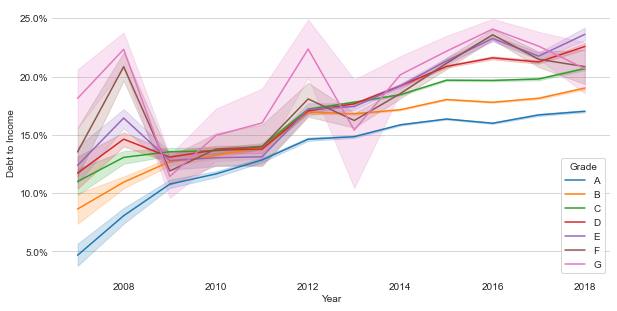

In [37]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=dfss, x = 'issue_year', y = 'dti', hue="grade", ax = ax, markers = 'o', ci = 95)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], title = "Grade")
ax.set_ylabel("Debt to Income")
ax.set_xlabel("Year")
ax.set_title(None)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.title.set_position([.5, 1.005])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid()
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_axisbelow(True)
plt.savefig('Images/Debt to Income by Year.png')
plt.show()

,Grade,Ratio,Mean Interest Rate,Default Rate,Mean Rate of Return,Median Rate of Return
0,A,25.37%,7.06%,3.82%,2.72%,5.96%
1,B,33.27%,10.67%,9.29%,1.06%,8.63%
2,C,26.11%,14.07%,15.11%,-2.52%,11.38%
3,D,11.43%,18.08%,20.51%,-7.49%,13.89%
4,E,3.14%,22.03%,25.50%,-13.40%,15.37%
5,F,0.54%,25.34%,34.03%,-24.15%,14.14%
6,G,0.13%,27.98%,40.47%,-40.44%,14.96%


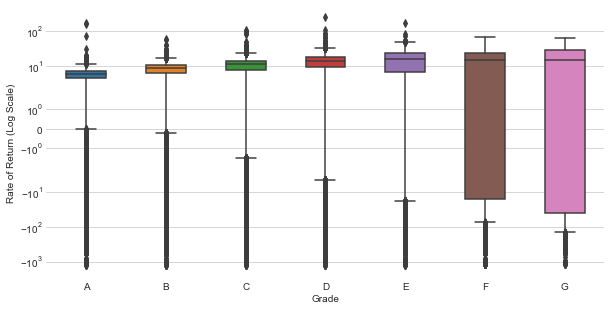

In [35]:
# Find the percentage of loans by grade, the default by grade, and the return of each grade. Assumes reinvestment at same return as loan returned upon early payoff or default.
perc_by_grade = (dfs.grade.value_counts()/len(dfs)).apply('{:.2%}'.format).sort_index()
default_by_grade = dfs.groupby("grade").apply(lambda x : len(x[x.loan_status == 'Default'])/len(x) ).apply('{:.2%}'.format)
int_rate_by_grade = dfs.groupby("grade").apply(lambda x : np.mean(x.int_rate)/100).apply('{:.2%}'.format)
mean_rate_of_return = dfs.groupby("grade").apply(lambda x : np.mean(x.rate_of_return)/100).apply('{:.2%}'.format)
median_rate_of_return = dfs.groupby("grade").apply(lambda x : np.median(x.rate_of_return)/100).apply('{:.2%}'.format)

combined = pd.DataFrame(perc_by_grade)
combined['Interest Rate'] = int_rate_by_grade
combined['Default Rate'] = default_by_grade
combined['Mean Rate of Return'] = mean_rate_of_return
combined['Median Rate of Return'] = median_rate_of_return

combined.reset_index(inplace = True)
combined.columns = ['Grade','Ratio', 'Mean Interest Rate', 'Default Rate', 'Mean Rate of Return', 'Median Rate of Return']

display(combined.style.set_table_styles([dict(selector="th",props=[('max-width', '75px')])]))

combined.to_csv("Tables/Summary Statistics by Grade.csv", index = False)

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='grade', y='rate_of_return', data = dfs, ax = ax, order = sorted(dfs.grade.unique()), width = 0.5)
ax.set_ylabel("Rate of Return (Log Scale)")
ax.set_xlabel("Grade")
ax.set_title(None)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_yscale('symlog')
ax.set_ylim(-3000, 500)
ax.title.set_position([.5, 1.005])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid()
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_axisbelow(True)
plt.savefig('Images/Distribution of Simple Annualized Rate of Return by Loan Grade.png')
plt.show()

In [28]:
display(dfs[['grade','verification_status']].groupby('verification_status').count())
display(dfs[['grade','home_ownership']].groupby('home_ownership').count())

,grade
verification_status,
Not Verified,570277
Verified,1022005


,grade
home_ownership,
MORTGAGE,726815
OWN,185284
RENT,680183


In [29]:
underwriting_df = dfs[['grade','emp_length','home_ownership','annual_inc','verification_status','avg_fico','dti']].groupby('grade').agg(
    {'emp_length':[np.mean],
     'annual_inc': [np.mean],
     'avg_fico': [np.mean],
     'dti': [np.mean],
     'verification_status':[lambda x: len(x[x == "Verified"])/len(x)*10000],
     'home_ownership':[lambda x: len(x[x == "RENT"])/len(x)*10000]})

# underwriting_df.columns = underwriting_df.columns.droplevel(1)
display(underwriting_df)

,emp_length,annual_inc,avg_fico,dti,verification_status,home_ownership
,mean,mean,mean,mean,<lambda>,<lambda>
grade,,,,,,
A,5.589980,84946.855129,730.174822,16.304645,5025.052233,3354.622781
B,5.447250,72551.772485,696.143126,17.879088,6302.326547,4264.795262
C,5.245108,66713.559323,686.652050,19.492550,7224.795575,4753.631554
D,5.155489,64124.202732,683.052617,20.721510,7456.262256,4917.907619
E,4.949849,61501.969492,681.901636,21.393950,8008.947652,5148.095628
F,4.807858,56571.223923,680.425440,20.596415,8321.091291,5506.587385
G,4.724766,62537.223776,678.280158,22.024515,8532.742491,5105.859183


### Some findings:
The lending club data was published so that investors can analyze the Lending Club algorithm for 2 purposes:
  1. Ensure that Lending Club is properly vetting the applicants.
  2. Enable the investors to decide for themselves whether or not to invest on the Lending Club platform and to analyze the risk profiles of the grades.

Interest rate does not increase as quickly as default rate. this implies that investing in lower grade loans will not only be riskier, but diversifying among those lower grade loans may actually perform worse overall. More investigation is required to determine how quickly these loans default. For example, if the borrower defaults near the end, the default is not as costly. Similarly, a good investment that is repayed early also incurs the cost of finding a new investment. This also assumes that investment payments are immediately reinvested as there can be significant time to find new investments. It is possible that additional features, such as 'purpose' may also be indicative of default rates.

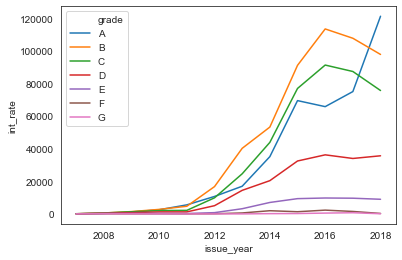

In [31]:
sns.set_style("white")
df_loans_issued = dfs.groupby([dfs.issue_year,'grade'])['int_rate'].count().to_frame().reset_index()
sns.lineplot(data=df_loans_issued, x = 'issue_year', y = 'int_rate', hue="grade")
# plt.yscale('log')

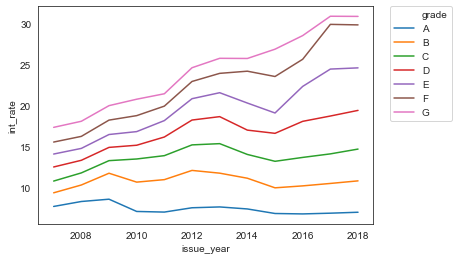

In [32]:
df_loans_issued = dfs.groupby([dfs.issue_year,'grade'])['int_rate'].mean().to_frame().reset_index()
sns.lineplot(data=df_loans_issued, x = 'issue_year', y = 'int_rate', hue="grade")
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Part 2: Data Engineering Code

### Generate Simple Table Schema from DataFrame

In [22]:
dft = df.iloc[-10:].copy()
dft['member_id'] = 1

from typing import List, Set, Dict, Tuple, Optional, Callable, Any
class Table:
    def __init__(self, pull_table: str, push_table: str, not_null:Optional[List[str]] = [], transformations: Optional[List[Tuple[List[str], Callable[[Any],Any]]]] = [], validations: Optional[List[Tuple[List[str], Callable[[Any],Any]]]] = [], dimensions: Optional[List[Tuple[str, Tuple[str,str], List[str]]]] = []):
        self.pull_table = pull_table
        self.push_table = push_table
        self.transformations = transformations
        self.not_null = not_null
        self.validations = validations
        self.dimensions = dimensions
    
    # Runs all the validation routines
    def validate(self, df):
        df = df[df[self.not_null].notnull().all(axis=1)]
        for cols,val in self.validations:
            df = val(df,cols)
        return df
    
    # Runs the transformation routines
    def transform(self, df):
        for cols,t in self.transformations:
            for col in cols:
                df[col] = t(df[col])
        return df
    
    # Divide dataframe into dimension tables
    def dimensionalize(self, df):
        df_arr = [[self.push_table, df]]
        for target, id_col, cols in self.dimensions:
            # Pulls out columns, links foreign keys, renames foreign key column and drops empty rows in linked tables
            df_arr.append([target, df_arr[0][1][[id_col[0]] + cols].rename({id_col[0]: id_col[1]}, axis = 1).dropna(axis = 0, how='all', subset = cols)])
            df_arr[0][1] = df.drop(columns = cols, axis = 1)
        return df_arr
    
    # Runs entire routine
    def prepare(self, df):
        return self.dimensionalize(self.transform(self.validate(df)))
    
    def __repr__(self):  
        return f"Pulling from: {self.pull_table}\nPushing to: {self.push_table}\nTransformations: {self.transformations}\nNon-Null Columns: {self.not_null}\nValidations: {self.validations}"

not_null = ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'application_type' , 'hardship_flag']
transformations = [
    (['emp_length'], lambda series: series.fillna(value = '0 years').replace({'< 1 year': '0 years', '10+ years': '10 years'}).str.extract('(\d+)',expand=False).astype(int)),
    (['term'], lambda series: series.str.extract('(\d+)',expand=False).astype(int)),
    (['hardship_flag'], lambda series: series.str.lower().replace({"n": False, "y": True}).astype(bool)),
    (['debt_settlement_flag'], lambda series: series.str.lower().replace({"n": False, "y": True}).astype(bool)),
    (["issue_d", "earliest_cr_line", "last_pymnt_d", "sec_app_earliest_cr_line", "hardship_start_date","hardship_end_date", "payment_plan_start_date","debt_settlement_flag_date","settlement_date","created_on","last_updated"], lambda series: pd.to_datetime(series, errors = 'coerce', infer_datetime_format = True))
]
validations = [
    (['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'annual_inc', 'zip_code', 'dti', 'fico_range_low', 'fico_range_high', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt'], lambda df,cols: df[(df[cols] >= 0).all(axis = 1)]),
]
dimensions = [
    ('HARDSHIP', ('id', 'loan_id'), ['hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount']),
    ('SETTLEMENT', ('id', 'loan_id'), ['debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term'])
]
test = Table('ACCEPTED', 'TARGET', transformations = transformations, not_null = not_null, validations = validations, dimensions = dimensions)
test.prepare(dft)

[['TARGET',
           id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  term  \
  0  68407277          1     3600.0       3600.0           3600.0    36   
  1  68355089          1    24700.0      24700.0          24700.0    36   
  2  68341763          1    20000.0      20000.0          20000.0    60   
  3  66310712          1    35000.0      35000.0          35000.0    60   
  4  68476807          1    10400.0      10400.0          10400.0    60   
  5  68426831          1    11950.0      11950.0          11950.0    36   
  6  68476668          1    20000.0      20000.0          20000.0    36   
  7  67275481          1    20000.0      20000.0          20000.0    36   
  8  68466926          1    10000.0      10000.0          10000.0    36   
  9  68616873          1     8000.0       8000.0           8000.0    36   
  
     int_rate  installment grade sub_grade  ... hardship_end_date  \
  0     13.99       123.03     C        C4  ...               NaT   
  1     11.99       82